<font size = "6"> Fordham Sports Analytics Society Big Data Bowl 2023 - Model Creation </font>

<font size = "4"> Build regression model to determine the distance of an individual rusher at the end of QB "Possession". </font>

- Authors:  Peter Majors, Chris Orlando, Jack Townsend, and Etienne Busnel
- Kaggle:  https://www.kaggle.com/competitions/nfl-big-data-bowl-2023/overview (Resources)
- Our Github:  https://github.com/peterlmajors/FSAS_BigDataBowl_2023 (Up-To-Date Code)

In [20]:
#Import Relevant Packages

#Data Manipulation
import pandas as pd
import numpy as np
from numpy import mean, std
import math

#Data Viz
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
plt.style.use('ggplot')
import seaborn as sns 
import plotly.graph_objects as go

#SKLearn
import sklearn
from sklearn.metrics import get_scorer_names, mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RepeatedKFold, KFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE

#Team Logos
import os
import urllib.request
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

#XGBoost
import xgboost as xgb
from xgboost import XGBRegressor, cv, plot_importance

#Statistics
from scipy.stats import pearsonr, spearmanr, uniform, randint

#Notebook Settings
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 1000)

In [21]:
#Import Model Ready Data
df = pd.read_csv("C:/Users/Peter/Python Scripts/Case Competitions/NFL Big Data Bowl 2023/merged_data/df_model.csv")

In [22]:
#Create Feature List
df_features = ['s_rusher_ff_out_imm_zone', 'rusher_dist_from_qb_diff_beg_end_imm_zone', 'diff_btw_rusher_dir_blocker_o_ff_in_imm', 'blocker_o_diff_beg_end_imm_zone', 
               'time_rusher_in_imm_zone', 'time_in_imm_zone_after_out', 'time_blocker_closer_to_qb_than_rusher']
        
#Target Variable
df_target = ['rusher_dist_from_qb_end_poss']

<font size = "5"> Data Preprocessing (Null Values) </font>

In [23]:
#Null Values
#Fill Time left In Immediate Zone Once Out As 0 If The Rusher Doesn't Re-Enter Or Never Leaves
df['time_in_imm_zone_after_out'] = df['time_in_imm_zone_after_out'].fillna(0)

<font size = "5"> Explore Relationships Between Features And Target Variable </font>

[Text(0.5, 1.0, 'Correlation Matrix of Continuous Variables')]

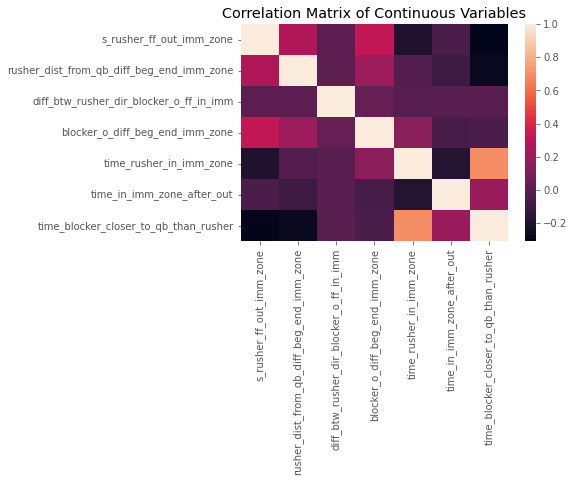

In [24]:
#Look At A Heatmap of Continuous Variables
sns.heatmap(df[df_features].corr()).set(title = "Correlation Matrix of Continuous Variables")

In [25]:
#Create Tackles & Guards and Centers DataFrames
df_t = df.loc[(df.pff_positionLinedUp == 'LT') | (df.pff_positionLinedUp == 'RT')]
df_gc = df.loc[(df.pff_positionLinedUp == 'C') | (df.pff_positionLinedUp == 'LG') | (df.pff_positionLinedUp == 'RG')]

In [26]:
#Categorical Values To Gropupby
# df.groupby('dropBackType')['rusher_dist_from_qb_end_poss'].mean()

#Cotinuous Correlations
# spearmanr(df.s_rusher_ff_imm_zone, df.rusher_dist_from_qb_end_poss)

<font size = '5' > Tackles Model Scaling and Fitting </font>

In [27]:
#Scaling On Tackles Data

#Standardize Continuous Values Around The Mean of 0
scaler = StandardScaler()
df_s_t = scaler.fit_transform(df_t[df_features])

#Turn It Back Into A Data Frame And Return Column Names
df_s_t = pd.DataFrame(df_s_t)
df_s_t.columns = df_features

In [28]:
#Prepare Features and Test/Train Split Manually (53% Train, 47% Test)

#Import The Standardized Tackle Data And Target Variables For Tackles
X_t = df_s_t[df_features]
y_t = df_t[df_target].reset_index(drop = True)

#Find Weeks For Plays In The Tackle Data
df_t_weeks = pd.DataFrame(df_t['week'].reset_index())

#Concat Onto X_t and y_t So Weeks Can Be Filtered
X_t = pd.concat([X_t, df_t_weeks], axis = 1, join = 'inner')
y_t = pd.concat([y_t, df_t_weeks], axis = 1, join = 'inner')

#Split Data By First Half/Second Half Of The Weeks To Make Model Interpretable Among Other Metrics

#Train Data (Wks 1-4)
X_train = X_t[X_t.week < 5]
y_train = y_t[y_t.week < 5]

#Test Data (Wks 5-8)
X_test = X_t[X_t.week > 4]
y_test = y_t[y_t.week > 4]

#Remove Unnecessary Columns
X_train, y_train, X_test, y_test = X_train[df_features], y_train[df_target], X_test[df_features], y_test[df_target]

#Check For Correct Shape
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(6659, 7) (6659, 1) (5872, 7) (5872, 1)


In [29]:
#Study Hyperparameters Using Cross Validation

# # #Assign Model
# model_t = XGBRegressor(n_estimators= 70, max_depth=6, eta = .05, subsample = .7, colsample_bytree = .8)

# # #Utilize Cross Validation To Further Enhance Model
# cv = RepeatedKFold(n_splits=10, n_repeats=8, random_state=1)
# scores = cross_val_score(model_t, X_train, y_train, cv=cv, scoring = 'neg_root_mean_squared_error', n_jobs = -1, error_score = 'raise')

# # scores = abs(scores)
# print('Mean RMSE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

In [30]:
#Update The Model Based On Cross Validation Tests and Fit and Balance Overfitting With Performance
model_t = XGBRegressor(objective = 'reg:squarederror', n_estimators= 70, max_depth = 4, eta = .05, subsample = .8, colsample_bytree = .9)
print("                 Test Set                        Train Set")
model_t.fit(X_train, y_train, eval_set=[(X_test, y_test), (X_train, y_train)]) #Check For Overfitting

                 Test Set                        Train Set
[0]	validation_0-rmse:4.00164	validation_1-rmse:3.94445
[1]	validation_0-rmse:3.82008	validation_1-rmse:3.76541
[2]	validation_0-rmse:3.64766	validation_1-rmse:3.59585
[3]	validation_0-rmse:3.48553	validation_1-rmse:3.43577
[4]	validation_0-rmse:3.33088	validation_1-rmse:3.28380
[5]	validation_0-rmse:3.20180	validation_1-rmse:3.15452
[6]	validation_0-rmse:3.08073	validation_1-rmse:3.03365
[7]	validation_0-rmse:2.94908	validation_1-rmse:2.90446
[8]	validation_0-rmse:2.82489	validation_1-rmse:2.78252
[9]	validation_0-rmse:2.70854	validation_1-rmse:2.66820
[10]	validation_0-rmse:2.59813	validation_1-rmse:2.55945
[11]	validation_0-rmse:2.49433	validation_1-rmse:2.45741
[12]	validation_0-rmse:2.39682	validation_1-rmse:2.36125
[13]	validation_0-rmse:2.31665	validation_1-rmse:2.28121
[14]	validation_0-rmse:2.24268	validation_1-rmse:2.20712
[15]	validation_0-rmse:2.15990	validation_1-rmse:2.12552
[16]	validation_0-rmse:2.08244	validati

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9, early_stopping_rounds=None,
             enable_categorical=False, eta=0.05, eval_metric=None,
             feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=70, n_jobs=None,
             num_parallel_tree=None, predictor=None, ...)

In [31]:
#Make Predictions On The Test Set

#Make Predictions On The Test Set
df_t_wks_5_8 = df_t[df_t.week > 4]
df_t_wks_5_8['pred_rusher_dist_from_qb_end_poss'] = model_t.predict(X_test)

#Calculate Mean Squared Error On Test Set
mse = mean_squared_error(y_test, df_t_wks_5_8.pred_rusher_dist_from_qb_end_poss)
r = pearsonr(df_t_wks_5_8.pred_rusher_dist_from_qb_end_poss, y_test)[0]
print(np.sqrt(mse), r)

1.1255054507421127 [0.8062729690847811]


C:\Users\Peter\AppData\Local\Temp\ipykernel_12672\1199255216.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_t_wks_5_8['pred_rusher_dist_from_qb_end_poss'] = model_t.predict(X_test)


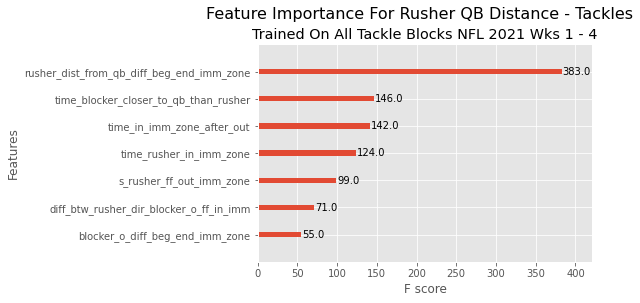

In [32]:
#Show Feature Importance
fig = plot_importance(model_t)
plt.title("Trained On All Tackle Blocks NFL 2021 Wks 1 - 4")
plt.suptitle('Feature Importance For Rusher QB Distance - Tackles', size = 16, y= 1.01)

plt.show()

<font size = '5' > Guards and Centers Model Scaling and Fitting </font>

In [33]:
#Scaling On Guards and Centers Data

#Standardize Continuous Values Around The Mean of 0
scaler = StandardScaler()
df_s_gc = scaler.fit_transform(df_gc[df_features])

#Turn It Back Into A Data Frame And Return Column Names
df_s_gc = pd.DataFrame(df_s_gc)
df_s_gc.columns = df_features

In [34]:
#Prepare Features and Test/Train Split Manually (53% Train, 47% Test)

#Import The Standardized Tackle Data And Target Variables For Tackles
X_gc = df_s_gc[df_features]
y_gc = df_gc[df_target].reset_index(drop = True)

#Find Weeks For Plays In The Tackle Data
df_gc_weeks = pd.DataFrame(df_gc['week'].reset_index())

#Concat Onto X_t and y_t So Weeks Can Be Filtered
X_gc = pd.concat([X_gc, df_gc_weeks], axis = 1, join = 'inner')
y_gc = pd.concat([y_gc, df_gc_weeks], axis = 1, join = 'inner')

#Split Data By First Half/Second Half Of The Weeks To Make Model Interpretable Among Other Metrics

#Train Data (Wks 1-4)
X_train = X_gc[X_gc.week < 5]
y_train = y_gc[y_gc.week < 5]

#Test Data (Wks 5-8)
X_test = X_gc[X_gc.week > 4]
y_test = y_gc[y_gc.week > 4]

#Remove Unnecessary Columns
X_train, y_train, X_test, y_test = X_train[df_features], y_train[df_target], X_test[df_features], y_test[df_target]

#Check For Correct Shape
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(9661, 7) (9661, 1) (8564, 7) (8564, 1)


In [35]:
# #Study Hyperparameters Using Cross Validation

# # #Assign Model
# model_gc = XGBRegressor(objective = 'reg:linear', n_estimators= 120, max_depth=8, eta = .05, subsample = .4, colsample_bytree = .8)

# # #Utilize Cross Validation To Further Enhance Model
# cv = RepeatedKFold(n_splits=10, n_repeats=8, random_state=1)
# scores = cross_val_score(model_gc, X_train, y_train, cv=cv, scoring = 'neg_root_mean_squared_error', n_jobs = -1, error_score = 'raise')

# # scores = abs(scores)
# print('Mean RMSE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

In [36]:
#Update The Model Based On Cross Validation Tests and Fit and Balance Overfitting With Performance
model_gc = XGBRegressor(objective = 'reg:squarederror', n_estimators= 70, max_depth = 6, eta = .05, subsample = .6, colsample_bytree = .9)
print("                 Test Set                        Train Set")
model_gc.fit(X_train, y_train, eval_set=[(X_test, y_test), (X_train, y_train)]) #Check For Overfitting

                 Test Set                        Train Set
[0]	validation_0-rmse:4.08408	validation_1-rmse:4.04860
[1]	validation_0-rmse:3.90133	validation_1-rmse:3.86752
[2]	validation_0-rmse:3.72889	validation_1-rmse:3.69581
[3]	validation_0-rmse:3.56661	validation_1-rmse:3.53417
[4]	validation_0-rmse:3.41235	validation_1-rmse:3.38032
[5]	validation_0-rmse:3.26656	validation_1-rmse:3.23525
[6]	validation_0-rmse:3.14262	validation_1-rmse:3.10933
[7]	validation_0-rmse:3.01309	validation_1-rmse:2.97961
[8]	validation_0-rmse:2.90236	validation_1-rmse:2.86733
[9]	validation_0-rmse:2.78820	validation_1-rmse:2.75188
[10]	validation_0-rmse:2.67880	validation_1-rmse:2.64162
[11]	validation_0-rmse:2.58754	validation_1-rmse:2.54816
[12]	validation_0-rmse:2.50117	validation_1-rmse:2.45984
[13]	validation_0-rmse:2.41086	validation_1-rmse:2.36818
[14]	validation_0-rmse:2.32602	validation_1-rmse:2.28144
[15]	validation_0-rmse:2.24580	validation_1-rmse:2.19943
[16]	validation_0-rmse:2.17167	validati

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9, early_stopping_rounds=None,
             enable_categorical=False, eta=0.05, eval_metric=None,
             feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=70, n_jobs=None,
             num_parallel_tree=None, predictor=None, ...)

In [37]:
#Make Predictions On The Test Set
df_gc_wks_5_8 = df_gc[df_gc.week > 4]
df_gc_wks_5_8['pred_rusher_dist_from_qb_end_poss'] = model_gc.predict(X_test)

#Calculate Mean Squared Error On Test Set
mse = mean_squared_error(y_test, df_gc_wks_5_8.pred_rusher_dist_from_qb_end_poss)
r = pearsonr(df_gc_wks_5_8.pred_rusher_dist_from_qb_end_poss, y_test)[0]
print(np.sqrt(mse), r)

1.2704434526046138 [0.7179289677878827]


C:\Users\Peter\AppData\Local\Temp\ipykernel_12672\1730457459.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_gc_wks_5_8['pred_rusher_dist_from_qb_end_poss'] = model_gc.predict(X_test)


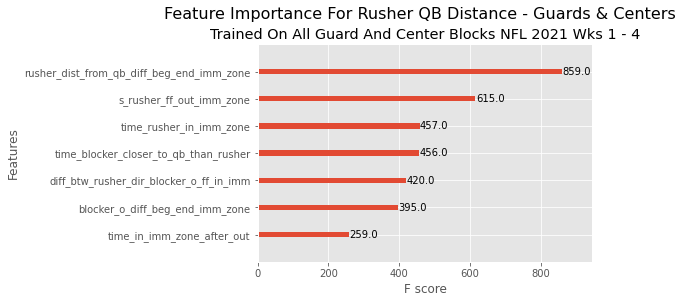

<Figure size 240x1600 with 0 Axes>

In [38]:
#Show Feature Importance
xgb.plot_importance(model_gc)
plt.title("Trained On All Guard And Center Blocks NFL 2021 Wks 1 - 4")
plt.suptitle('Feature Importance For Rusher QB Distance - Guards & Centers', size = 16, y= 1.01)
figure(figsize=(3, 20), dpi=80)
plt.show()

<font size = '5' > Data Visualizations On Teams and Players </font>

In [39]:
#Apply Snap Threshold For Players

#Institute Minimum of Snaps For Tackles In Weeks 5-8 (Max 169) - 70 Snaps Includes Top 48 Players of 99 Total
df_t_wks_5_8_min = df_t_wks_5_8.groupby("displayName").count()['game_play_nfl_Id'].sort_values(ascending = False).reset_index()
df_t_wks_5_8_min = df_t_wks_5_8_min[df_t_wks_5_8_min.game_play_nfl_Id > 70]

#Institute Minimum of Snaps For Guards In Weeks 5-8 (Max 168) - 70 Snaps Includes Top 83 Players of 129 Total
df_gc_wks_5_8_min = df_gc_wks_5_8.groupby("displayName").count()['game_play_nfl_Id'].sort_values(ascending = False).reset_index()
df_gc_wks_5_8_min = df_gc_wks_5_8_min[df_gc_wks_5_8_min.game_play_nfl_Id > 70]

#Institute Minimum of Snaps For Tackles In Weeks 1-4 (Max 166) - 70 Snaps Includes Top 58 Players of 100 Total
df_t_wks_1_4 = df_t[df_t.week < 5]
df_t_wks_1_4_min = df_t_wks_1_4.groupby("displayName").count()['game_play_nfl_Id'].sort_values(ascending = False).reset_index()
df_t_wks_1_4_min = df_t_wks_1_4_min[df_t_wks_1_4_min.game_play_nfl_Id > 70]

#Institute Minimum of Snaps For Guards and Centers In Weeks 1-4 (Max 160) - 70 Snaps Includes Top 88 Players of 136 Total
df_gc_wks_1_4 = df_gc[df_gc.week < 5]
df_gc_wks_1_4_min = df_gc_wks_1_4.groupby("displayName").count()['game_play_nfl_Id'].sort_values(ascending = False).reset_index()
df_gc_wks_1_4_min = df_gc_wks_1_4_min[df_gc_wks_1_4_min.game_play_nfl_Id > 70]

print("\nWeeks 5-8 Thresholds")
print("Tackles", df_t_wks_5_8_min.shape, "Guards and Centers", df_gc_wks_5_8_min.shape)

print("\nWeeks 1-4 Thresholds")
print("Tackles", df_t_wks_1_4_min.shape, "Guards and Centers", df_gc_wks_1_4_min.shape)

#Tackles Threshold
df_t_min = df_t_wks_1_4_min.merge(df_t_wks_5_8_min, on = 'displayName', how = 'inner')
df_gc_min = df_gc_wks_1_4_min.merge(df_gc_wks_5_8_min, on = 'displayName', how = 'inner')

print("\nTotal Thresholds, Players Remaining")
print("Tackles", df_t_min.shape, "Guards and Centers", df_gc_min.shape)

#Merge These Onto Their Week 5-8 Data
# df_t_wks_5_8 = df_t_wks_5_8.merge(df_t_min, on = 'displayName', how = 'inner')
df_t_wks_5_8 = df_t_wks_5_8[df_t_wks_5_8['displayName'].isin(df_t_min['displayName'])]
# df_gc_wks_5_8 = df_gc_wks_5_8.merge(df_gc_min, on = 'displayName', how = 'inner')
df_gc_wks_5_8 = df_gc_wks_5_8[df_gc_wks_5_8['displayName'].isin(df_gc_min['displayName'])]

#Must Have 70 Plays In Weeks 1-4 and Weeks 5-8
#There Are Now 36 Tackles And 64 Guards/Centers In Considerations



Weeks 5-8 Thresholds
Tackles (43, 2) Guards and Centers (68, 2)

Weeks 1-4 Thresholds
Tackles (51, 2) Guards and Centers (78, 2)

Total Thresholds, Players Remaining
Tackles (29, 3) Guards and Centers (53, 3)


In [40]:
#Merge 1-4 and 5-8 Data Together For Guards
df_gc_1_4 = df.loc[(df['pff_positionLinedUp'] == 'C') | (df['pff_positionLinedUp'] == 'RG') | (df['pff_positionLinedUp']== 'LG')]
df_gc_1_4 = df_gc_1_4[(df_gc_1_4.week < 5)]

In [41]:
#Look At Best Centers And Guards In Football
pred_rusher_dist_from_qb_end_poss = df_gc_wks_5_8.groupby("team")['pred_rusher_dist_from_qb_end_poss'].mean().reset_index()
rusher_dist_from_qb_end_poss = df_gc_wks_5_8.groupby("team")['rusher_dist_from_qb_end_poss'].mean().reset_index()
df_gc = rusher_dist_from_qb_end_poss.merge(pred_rusher_dist_from_qb_end_poss, on = "team", how = 'inner')

In [44]:
#Correlation Tests
y = df_gc['rusher_dist_from_qb_end_poss']
x = df_gc['pred_rusher_dist_from_qb_end_poss']

pearsonr(x,y)

(0.6131018561797799, 0.00086773427590075)

In [45]:
#Setup Viz

# Dependencies
import nfl_data_py as nfl
import pandas as pd
import numpy as np
import os
import urllib.request
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

# Pull the team description 
logos = nfl.import_team_desc()

# Keep only the necessary columns in the logos DataFrame
logos = logos[['team_abbr', 'team_logo_espn']]


# Initialize an empty list for the logo file paths
logo_paths = []
# Initialize an empty list for the team abbreviations
team_abbr = []

# Create a folder for the image files if it doesn't exist
if not os.path.exists("logos"):
    os.makedirs("logos")
    
# Pull the team logos from the URL and save them in the logos folder, save the file paths to
for team in range(len(logos)):
    urllib.request.urlretrieve(logos['team_logo_espn'][team], f"logos/{logos['team_abbr'][team]}.tif")
    logo_paths.append(f"logos/{logos['team_abbr'][team]}.tif")
    team_abbr.append(logos['team_abbr'][team])

# Create a dictionary to put logo_paths and team_abbr in
data = {'Team Abbr' : team_abbr, 'Logo Path' : logo_paths}

# Create a DataFrame from the dictionary
logo_df = pd.DataFrame(data)

#Setup Viz
df_t_team = pd.merge(df_t, logo_df, left_on = 'team', right_on = 'Team Abbr', how = 'left')

# Define a function for getting the image path and loading it into the visualization
def getImage(path):
    return OffsetImage(plt.imread(path, format="tif"), zoom=.1)


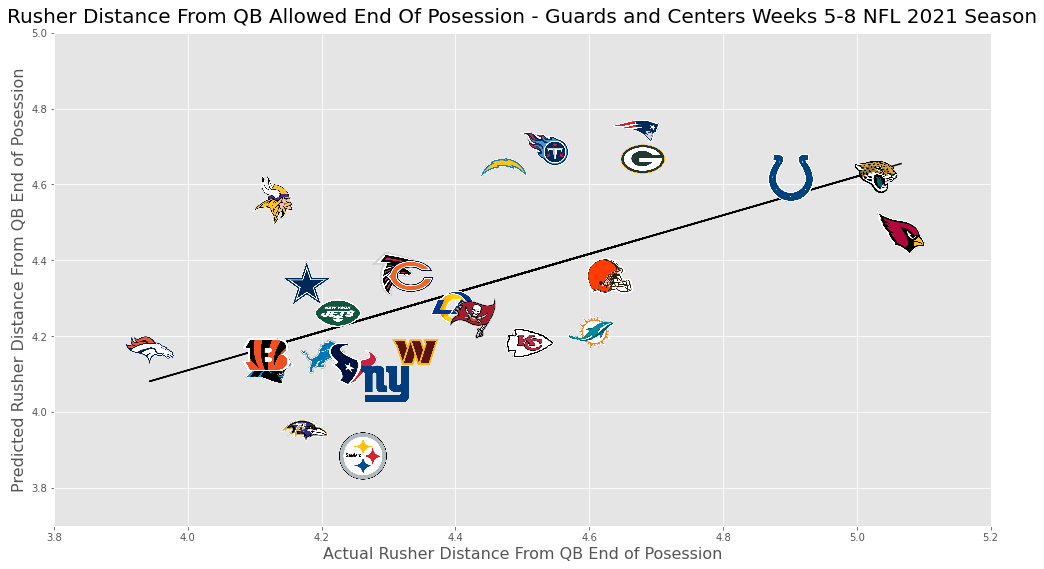

In [46]:
#Display Viz
df_gc_team = pd.merge(df_gc, logo_df, left_on = 'team', right_on = 'Team Abbr', how = 'left')

#  Define plot size and autolayout
plt.rcParams["figure.figsize"] = [20, 14]
plt.rcParams["figure.autolayout"] = True

# Define the x and y variables
x = df_gc['rusher_dist_from_qb_end_poss']
y = df_gc['pred_rusher_dist_from_qb_end_poss']

# Define the image paths
paths = df_gc_team['Logo Path']

# Define the plot
fig, ax = plt.subplots(figsize=(14,8))

plt.xlim(3.8, 5.2)
plt.ylim(3.7, 5)

m, b = np.polyfit(x, y,1)
plt.plot(x, m*x+b, color='black')

# Load the data into the plot
for x0, y0, path in zip(x, y, paths):
   ab = AnnotationBbox(getImage(path), (x0, y0), frameon=False)
   ax.add_artist(ab)

# Plot Parameters
plt.title("Rusher Distance From QB Allowed End Of Posession - Guards and Centers Weeks 5-8 NFL 2021 Season", fontdict={'fontsize':20}, y = 1.01);
plt.xlabel("Actual Rusher Distance From QB End of Posession", fontdict={'fontsize':16});
plt.ylabel("Predicted Rusher Distance From QB End of Posession", fontdict={'fontsize':16});

In [47]:
#NFL Teamn Colors
nfl_team_colors = {'ARI':'#97233F','ATL':'#A71930','BAL':'#241773','BUF':'#00338D','CAR':'#0085CA','CHI':'#00143F',
          'CIN':'#FB4F14','CLE':'#FB4F14','DAL':'#B0B7BC','DEN':'#002244','DET':'#046EB4','GB':'#24423C',
          'HOU':'#C9243F','IND':'#003D79','JAX':'#136677','KC':'#CA2430','LA':'#002147','LAC':'#2072BA',
          'MIA':'#0091A0','MIN':'#4F2E84','NE':'#0A2342','NO':'#A08A58','NYG':'#192E6C','NYJ':'#203731',
          'OAK':'#C4C9CC','PHI':'#014A53','PIT':'#FFC20E','SEA':'#7AC142','SF':'#C9243F','TB':'#D40909',
          'TEN':'#4095D1','WAS':'#FFC20F'}